In [1]:
# Importing needed packages

import osmnx as ox
import folium
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians

In [2]:
# Getting all the cinemas in Rome into a geopandas DF from OSMNX by using the tags "amenity":"cinema"
gdf = ox.geometries_from_place("Rome, Italy", {"amenity": "cinema"})
print(gdf.shape)
gdf.head()

(59, 56)


amenity                 name  \
element_type osmid                                    
node         248663946  cinema  Cineclub Alphaville   
             248674890  cinema         Nuovo Sacher   
             248676601  cinema                Reale   
             250884088  cinema             EUR Cine   
             250889369  cinema      Quattro Fontane   

                                         geometry addr:city addr:country  \
element_type osmid                                                         
node         248663946  POINT (12.53391 41.88741)       NaN          NaN   
             248674890  POINT (12.47267 41.88422)       NaN          NaN   
             248676601  POINT (12.47438 41.88932)      Roma           IT   
             250884088  POINT (12.46847 41.83388)       NaN          NaN   
             250889369  POINT (12.49199 41.90141)      Roma           IT   

                       addr:housenumber                addr:street  \
element_type osmid                                                   
node         248663946              NaN                        NaN   
             248674890              NaN                        NaN   
             248676601                3      Piazza Sidney Sonnino   
             250884088               32                  Via Liszt   
             250889369               23  Via delle Quattro Fontane   

                                 phone addr:postcode wheelchair  ...  \
element_type osmid                                               ...   
node         248663946             NaN           NaN        NaN  ...   
             248674890             NaN           NaN        NaN  ...   
             248676601  +39 06 5810234           NaN        NaN  ...   
             250884088             NaN         00144        NaN  ...   
             250889369             NaN         00184        yes  ...   

                       payment:visa_electron wikipedia building:levels  \
element_type osmid                                                       
node         248663946                   NaN       NaN             NaN   
             248674890                   NaN       NaN             NaN   
             248676601                   NaN       NaN             NaN   
             250884088                   NaN       NaN             NaN   
             250889369                   NaN       NaN             NaN   

                       roof:shape tourism opening_hours:signed roof:levels  \
element_type osmid                                                           
node         248663946        NaN     NaN                  NaN         NaN   
             248674890        NaN     NaN                  NaN         NaN   
             248676601        NaN     NaN                  NaN         NaN   
             250884088        NaN     NaN                  NaN         NaN   
             250889369        NaN     NaN                  NaN         NaN   

                       addr:housename ways type  
element_type osmid                               
node         248663946            NaN  NaN  NaN  
             248674890            NaN  NaN  NaN  
             248676601            NaN  NaN  NaN  
             250884088            NaN  NaN  NaN  
             250889369            NaN  NaN  NaN  

[5 rows x 56 columns]

<AxesSubplot:>

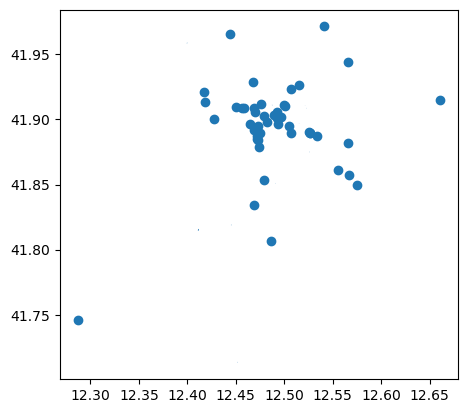

In [3]:
# Plotting the position of cinemas in Rome
gdf.plot()

In [4]:
# Creating a folium map with centroid on Rome
map_f = folium.Map(location=[41.8528, 12.4824], tiles='Stamen Watercolor', zoom_start=11)

# Transforming the geopandas DF to geojson, then adding a popup marker to each feature in the geojson, then adding them to the folium map
geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j)
folium.features.GeoJsonPopup(fields=['name'], labels=False).add_to(geo_j)
geo_j.add_to(map_f)

# Since the previous method to add pop-ups only work for point geometries, we "manually" add the markers associated with polygons
for i in range(0,len(gdf)):
    if gdf.iloc[i]['geometry'].geom_type == "Polygon":
        folium.Marker(
            location=[gdf.iloc[i]['geometry'].centroid.y, gdf.iloc[i]['geometry'].centroid.x],
            popup=gdf.iloc[i]['name'],
            icon=folium.Popup(),
        ).add_to(map_f)
        
# Plotting the resulting map                       
map_f

In [62]:
# Getting a list for lat, lng and name of each cinema in the gdf
lng = []
lat = []
names = []
for i in range(0,len(gdf)):
    if gdf.iloc[i]['geometry'].geom_type == "Point":
        long = gdf.iloc[i]['geometry'].x
        lng.append(long)
        lati = gdf.iloc[i]['geometry'].y
        lat.append(lati)
    # As before, points behave differently from polygons, so we get their coordinates with the .centroid attribute
    else:
        long = gdf.iloc[i]['geometry'].centroid.x
        lng.append(long)
        lati = gdf.iloc[i]['geometry'].centroid.y
        lat.append(lati)
    name = gdf.iloc[i]['name']
    names.append(name)

In [63]:
# Constructing a DF with the lats, longs and names previously obtained
cinemas = pd.DataFrame(list(zip(names, lat, lng)), columns =['name', 'lat', 'lng'])
cinemas.head()

,name,lat,lng
0,Cineclub Alphaville,41.887409,12.533910
1,Nuovo Sacher,41.884219,12.472672
2,Reale,41.889320,12.474378
3,EUR Cine,41.833877,12.468472
4,Quattro Fontane,41.901408,12.491988


In [65]:
# Computing earth distances for every pair of cinemas to find the most central one
names = cinemas.iloc[:,0].values
latitudes = cinemas.iloc[:,1].values
longitudes = cinemas.iloc[:,2].values

latitudes = [radians(i) for i in latitudes]
longitudes = [radians(i) for i in longitudes]

# Approx radius of earth (km)
r = 6371

earth_distances = [] # empty list for earth distances
# For loop to compute the haversine function on each cinema
for i in range(len(latitudes)):
    distances = []
    # Double for loop to apply the haversine function to every possible combination of cinemas
    for j in range(len(latitudes)):
        haversine = r * (2 * atan2(sqrt(sin((latitudes[i] - latitudes[j]) / 2)**2 + cos(latitudes[i]) * cos(latitudes[j]) * sin((longitudes[i] - longitudes[j]) / 2)**2), 
                                   sqrt(1 - sin((latitudes[i] - latitudes[j]) / 2)**2 + cos(latitudes[i]) * cos(latitudes[j]) * sin((longitudes[i] - longitudes[j]) / 2)**2)))
        distances.append(haversine)
    earth_distances.append(distances) # creating a list of lists to have every combination of distances, with each row representing a capital and the distances to every other capital

In [73]:
avg_distance = [] # empty list to store average distance for each cinema in relation to the other cinemas
for i in range(len(earth_distances)):
    avg_distance.append(np.mean(earth_distances[i]))

# Dictionary with cinema name and avg distance
distanceCinema = {names[i] : avg_distance[i] for i in range(len(names))}  

# Loop to find the lowest avg distance
for cinema, distance in distanceCinema.items():
    if distance == min(avg_distance):
        print("The roman cinema with the smallest average distance to the rest of cinemas is:", 
              cinema, "with an avg distance of", round(distance,2), "km")

for cinema, distance in distanceCinema.items():
    if distance == max(avg_distance):
        print("The roman cinema with the biggest average distance to the rest of cinemas is:", 
              cinema, "with an avg distance of", round(distance,2), "km")

The roman cinema with the smallest average distance to the rest of cinemas is: Quattro Fontane with an avg distance of 4.65 km
The roman cinema with the biggest average distance to the rest of cinemas is: Cineland with an avg distance of 23.48 km


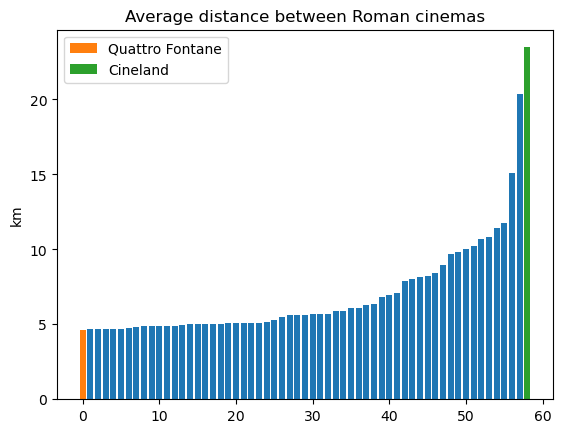

In [75]:
# Bar chart with the sorted avg values
plt.bar(range(len(latitudes)), sorted(avg_distance))
plt.bar(0, sorted(avg_distance)[0], label="Quattro Fontane")
plt.bar(58, sorted(avg_distance)[58], label="Cineland")
plt.title("Average distance between Roman cinemas")
plt.ylabel("km")
plt.legend(loc='best')
plt.show()

In [108]:
# Getting coordinates for the most and least central cinemas
smallest = cinemas.loc[cinemas['name'] == "Quattro Fontane"]
biggest = cinemas.loc[cinemas['name'] == "Cineland"]
print(smallest)
print(biggest)

              name        lat        lng
4  Quattro Fontane  41.901408  12.491988
        name        lat       lng
14  Cineland  41.746259  12.28691


In [124]:
# Adding the circles to the folium map corresponding the most and least central cinemas
folium.Circle(
    radius=1000,
    location=[41.901408, 12.491988],
    popup="Area around most central cinema",
    color="red",
    fill=True,
    fill_color="red",
).add_to(map_f)

folium.Circle(
    radius=1000,
    location=[41.746259, 12.28691],
    popup="Area around least central cinema",
    color="blue",
    fill=True,
    fill_color="blue",
).add_to(map_f)

map_f